# LDA with Gibbs Sampling

## Import Libraries

In [21]:
import numpy as np
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
from nltk.corpus import reuters, wordnet as wn
from nltk.corpus import stopwords
from LDA import LDA_gibbs
from LDA_var import LDA_gibbs_var
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

In [2]:
stops = stopwords.words("english")
# Add additional stop words
stops += [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed"
]

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

### Dataset 1: NLTK reuters
    a dataset of new articles, using the titles

In [5]:
# fetch titles only, 2000 docs only 
dataset = []
vocab = []

i = 0
for file_id in reuters.fileids():
    
    doc = [get_lemma(w.lower()) for w in reuters.words(file_id) \
                 if (w.isupper()) \
                 if (w.lower() not in stops) \
                 and (not w.isnumeric())]
    if doc:
        doc = [t for t in doc if len(t) > 1]
        dataset.append(doc)
        vocab += doc
        i += 1

    if i >= 2000:
        break

dataset = [[token for token in sublist if len(token) > 1] for sublist in dataset]

In [6]:
print(len(dataset))

2000


In [7]:
dataset

[['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mc', 'miti'],
 ['china', 'daily', 'say', 'vermin', 'eat', 'pct', 'grain', 'stocks'],
 ['japan',
  'revise',
  'long',
  'term',
  'energy',
  'demand',
  'downwards',
  'miti',
  'miti',
  'miti',
  'miti'],
 ['thai', 'trade', 'deficit', 'widen', 'quarter'],
 ['indonesia',
  'see',
  'cpo',
  'price',
  'rising',
  'sharply',
  'cpo',
  'fob',
  'cpo',
  'cif',
  'cpo'],
 ['australian',
  'foreign',
  'ship',
  'ban',
  'end',
  'nsw',
  'port',
  'hit',
  'nsw',
  'nsw',
  'nsw',
  'nsw'],
 ['indonesian', 'commodity', 'exchange', 'expand', 'cpo', 'fob', 'fob'],
 ['sri', 'lanka', 'get', 'usda', 'approval', 'wheat', 'price'],
 ['western',
  'mining',
  'open',
  'new',
  'gold',
  'australia',
  'wmng',
  'wmc',
  'wmc',
  'gra',
  'wmc'],
 ['sumitomo', 'bank', 'aim', 'quick', 'recovery', 'merger', 'sumi'],
 ['subroto',
  'say',
  'indonesia',
  'support',
  'tin',
  'pact',
  'extension',
  'ita',
  'ita',
  'ita'],
 ['bundesba

### Dataset 2: dataset.csv
    a dataset of research paper titles

In [8]:
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [9]:
def tokenize_text(text):
    tokens = tokenize(text)
    tokens = [t for t in tokens if len(t) > 4]
    tokens = [t for t in tokens if t not in stops]
    tokens = [get_lemma(t) for t in tokens]
    return tokens

In [10]:
dataset2 = []
vocab2 = []
with open('dataset.csv') as f:
    for line in f:
        tokened_line = tokenize_text(line)
        vocab2 += tokened_line
        dataset2.append(tokened_line)

In [11]:
print(len(dataset2))

2507


In [12]:
dataset2

[['innovation',
  'database',
  'management',
  'computer',
  'science',
  'engineering'],
 ['performance', 'prime', 'field', 'multiplication'],
 ['enchant',
  'scissors',
  'scissor',
  'interface',
  'support',
  'cutting',
  'interactive',
  'fabrication'],
 ['detection',
  'channel',
  'degradation',
  'attack',
  'intermediary',
  'linear',
  'network'],
 ['pinning', 'complex', 'network', 'betweenness', 'centrality', 'strategy'],
 ['analysis', 'design', 'memoryless', 'interconnect', 'encoding', 'scheme'],
 ['dynamic', 'bluescreens'],
 ['quantitative', 'assure', 'forwarding', 'service'],
 ['automatic',
  'sanitization',
  'social',
  'network',
  'prevent',
  'inference',
  'attack'],
 ['916;&#931',
  'radar',
  'range',
  'capability',
  'human',
  'monitoring',
  'system'],
 ['architecture', 'multi', 'memory', 'system', 'operation'],
 ['base', 'service', 'customization', 'houdini'],
 ['business', 'policy', 'modeling', 'enforcement', 'database'],
 ['speed', 'linearity', 'power', '

## Preping data for LDA

### For Dataset 1

In [13]:
vocab = list(set(vocab))
word_to_ix = {w: i for i, w in enumerate(vocab)}

def seq_to_ix(seq, vocab=vocab):
    # len(vocab), which is the last index, is for the <unk> (unknown) token
    unk_idx = len(vocab)
    return np.array(list(map(lambda w: word_to_ix.get(w, unk_idx), seq)))

data = {
    "data1": list(map(seq_to_ix, dataset))
}
docs = data["data1"]

### For Dataset 2

In [14]:
vocab2 = list(set(vocab2))
word_to_ix2 = {w: i for i, w in enumerate(vocab2)}

def seq_to_ix(seq, vocab=vocab2):
    # len(vocab), which is the last index, is for the <unk> (unknown) token
    unk_idx = len(vocab)
    return np.array(list(map(lambda w: word_to_ix2.get(w, unk_idx), seq)))

data = {
    "data2": list(map(seq_to_ix, dataset2))
}
docs2 = data["data2"]

## LDA with Gibbs

### Run Gibbs for Dataset 1

In [16]:
lda_news = LDA_gibbs_var(docs, vocab, n_topic=10)
b_s, t_s = lda_news.run_gibbs()

V: 3860
k: 10
N: [ 8  8 11  5 11 12  7  7 11  7]...
M: 2000
alpha: [1.18335424]
_eta: [1.03715177]
n_iw: dim (10, 3860)
n_di: dim (2000, 10)
assign: dim (2000, 70, 2001)

 ========== START SAMPLER ==========
Sampled 50/2000
Sampled 100/2000
Sampled 150/2000
Sampled 200/2000
Sampled 250/2000
Sampled 300/2000
Sampled 350/2000
Sampled 400/2000
Sampled 450/2000
Sampled 500/2000
Sampled 550/2000
Sampled 600/2000
Sampled 650/2000
Sampled 700/2000
Sampled 750/2000
Sampled 800/2000
Sampled 850/2000
Sampled 900/2000
Sampled 950/2000
Sampled 1000/2000
Sampled 1050/2000
Sampled 1100/2000
Sampled 1150/2000
Sampled 1200/2000
Sampled 1250/2000
Sampled 1300/2000
Sampled 1350/2000
Sampled 1400/2000
Sampled 1450/2000
Sampled 1500/2000
Sampled 1550/2000
Sampled 1600/2000
Sampled 1650/2000
Sampled 1700/2000
Sampled 1750/2000
Sampled 1800/2000
Sampled 1850/2000
Sampled 1900/2000
Sampled 1950/2000
Sampled 2000/2000


In [36]:
lda_research = LDA_gibbs_var(docs2, vocab2, n_topic=10)
b_s2, t_s2 = lda_research.run_gibbs()

V: 3389
k: 10
N: [6 4 8 7 6 6 2 4 7 7]...
M: 2507
alpha: [1.18335424]
_eta: [1.03715177]
n_iw: dim (10, 3389)
n_di: dim (2507, 10)
assign: dim (2507, 22, 2001)

 ========== START SAMPLER ==========
Sampled 50/2000
Sampled 100/2000
Sampled 150/2000
Sampled 200/2000
Sampled 250/2000
Sampled 300/2000
Sampled 350/2000
Sampled 400/2000
Sampled 450/2000
Sampled 500/2000
Sampled 550/2000
Sampled 600/2000
Sampled 650/2000
Sampled 700/2000
Sampled 750/2000
Sampled 800/2000
Sampled 850/2000
Sampled 900/2000
Sampled 950/2000
Sampled 1000/2000
Sampled 1050/2000
Sampled 1100/2000
Sampled 1150/2000
Sampled 1200/2000
Sampled 1250/2000
Sampled 1300/2000
Sampled 1350/2000
Sampled 1400/2000
Sampled 1450/2000
Sampled 1500/2000
Sampled 1550/2000
Sampled 1600/2000
Sampled 1650/2000
Sampled 1700/2000
Sampled 1750/2000
Sampled 1800/2000
Sampled 1850/2000
Sampled 1900/2000
Sampled 1950/2000
Sampled 2000/2000


In [17]:
def calculate_posterior_variance(samples):
    # Stack the samples to a 3D array for easier computation
    stack = np.stack(samples, axis=0)

    # Calculate variance along the sample axis (axis=0)
    var = np.var(stack, axis=0)
    
    return var

In [38]:
posterior_variance_beta = calculate_posterior_variance(b_s)
posterior_variance_beta2 = calculate_posterior_variance(b_s2)
posterior_variance_theta = calculate_posterior_variance(t_s)

In [19]:
posterior_variance_beta

array([[4.95564542e-09, 2.61809853e-08, 5.86171292e-08, ...,
        3.29052971e-09, 1.58627012e-08, 6.91822111e-09],
       [3.01761175e-09, 2.82872101e-08, 3.16082057e-08, ...,
        3.40290674e-09, 1.52708481e-08, 9.08173406e-09],
       [4.35039476e-09, 2.80035864e-08, 2.88594333e-08, ...,
        2.76844413e-09, 1.10236435e-08, 6.46766497e-09],
       ...,
       [2.12167995e-09, 3.81528541e-08, 3.11522880e-08, ...,
        3.73289507e-09, 1.18740293e-08, 9.11567609e-09],
       [3.30268502e-09, 2.65319646e-08, 2.64639082e-08, ...,
        3.49814478e-09, 1.13053324e-08, 7.79978768e-09],
       [1.70229639e-09, 1.70357614e-08, 1.75103434e-08, ...,
        2.92735553e-09, 9.24628042e-09, 5.40992063e-09]])

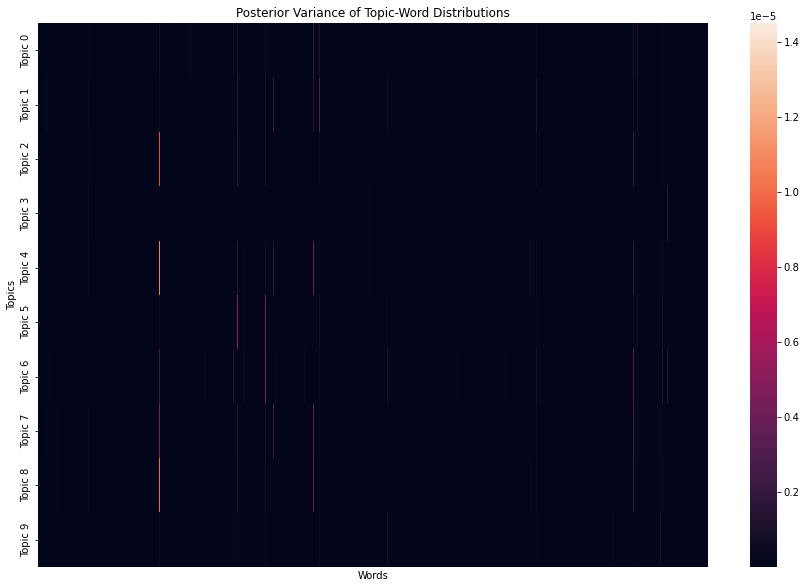

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(posterior_variance_beta, xticklabels=[],yticklabels=['Topic ' + str(i) for i in range(posterior_variance_beta.shape[0])])
plt.title('Posterior Variance of Topic-Word Distributions')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()

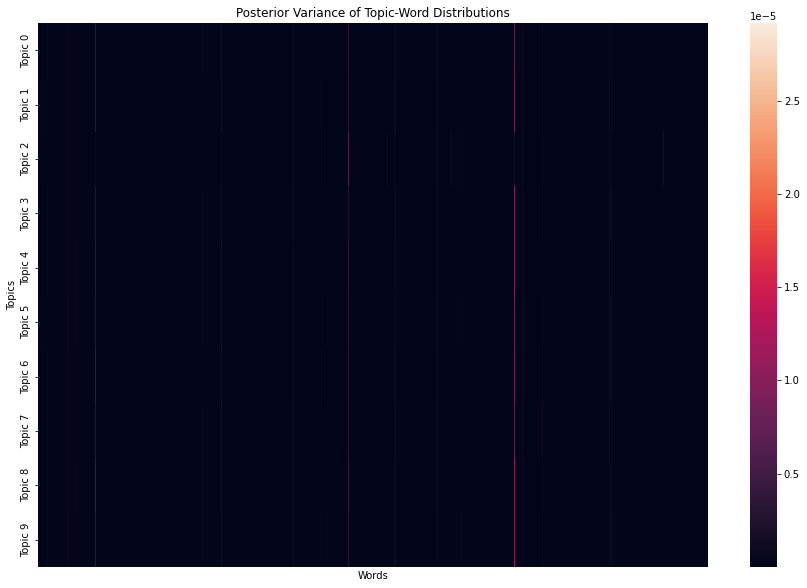

In [39]:
plt.figure(figsize=(15, 10))
sns.heatmap(posterior_variance_beta2, xticklabels=[],yticklabels=['Topic ' + str(i) for i in range(posterior_variance_beta2.shape[0])])
plt.title('Posterior Variance of Topic-Word Distributions')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()

In [40]:
beta = np.empty((lda_research.k,lda_research.V))
theta = np.empty((lda_research.M, lda_research.k))

for j in range(lda_research.V):
    for i in range(lda_research.k):
        beta[i, j] = (lda_research.n_iw[i, j] + lda_research.eta) / (lda_research.n_iw[i, :].sum() + lda_research.V*lda_research.eta)

for d in range(lda_research.M):
    for i in range(lda_research.k):
        theta[d, i] = (lda_research.n_di[d, i] + lda_research.alpha) / (lda_research.n_di[d, :].sum() + lda_research.k*lda_research.alpha)

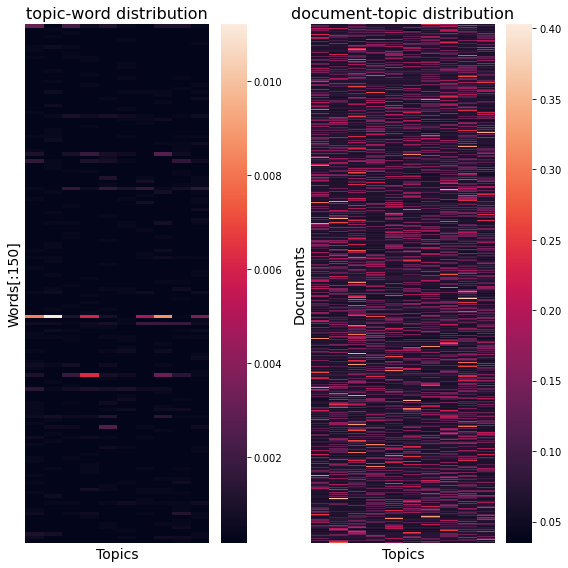

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(121)
n_plot_words = 150
sns.heatmap(beta.T[:n_plot_words], xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel(f"Words[:{n_plot_words}]", fontsize=14)
plt.title("topic-word distribution", fontsize=16)

plt.subplot(122)
sns.heatmap(theta, xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Documents", fontsize=14)
plt.title("document-topic distribution", fontsize=16)

plt.tight_layout()

In [ ]:
beta = np.empty((lda_news.k,lda_news.V))
theta = np.empty((lda_news.M, lda_news.k))

for j in range(lda_news.V):
    for i in range(lda_news.k):
        beta[i, j] = (lda_news.n_iw[i, j] + lda_news.eta) / (lda_news.n_iw[i, :].sum() + lda_news.V*lda_news.eta)

for d in range(lda_news.M):
    for i in range(lda_news.k):
        theta[d, i] = (lda_news.n_di[d, i] + lda_news.alpha) / (lda_news.n_di[d, :].sum() + lda_news.k*lda_news.alpha)

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(121)
n_plot_words = 150
sns.heatmap(beta.T[:n_plot_words], xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel(f"Words[:{n_plot_words}]", fontsize=14)
plt.title("topic-word distribution", fontsize=16)

plt.subplot(122)
sns.heatmap(theta, xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Documents", fontsize=14)
plt.title("document-topic distribution", fontsize=16)

plt.tight_layout()

### Run Gibbs for Dataset 2

In [15]:
lda_research = LDA_gibbs(docs2, vocab2, n_topic=10)
lda_research.run_gibbs()

V: 3389
k: 10
N: [6 4 8 7 6 6 2 4 7 7]...
M: 2507
alpha: [1.18335424]
_eta: [1.03715177]
n_iw: dim (10, 3389)
n_di: dim (2507, 10)
assign: dim (2507, 22, 2001)

 ========== START SAMPLER ==========
Sampled 50/2000
Sampled 100/2000
Sampled 150/2000
Sampled 200/2000
Sampled 250/2000
Sampled 300/2000
Sampled 350/2000
Sampled 400/2000
Sampled 450/2000
Sampled 500/2000
Sampled 550/2000
Sampled 600/2000
Sampled 650/2000
Sampled 700/2000
Sampled 750/2000
Sampled 800/2000
Sampled 850/2000
Sampled 900/2000
Sampled 950/2000
Sampled 1000/2000
Sampled 1050/2000
Sampled 1100/2000
Sampled 1150/2000
Sampled 1200/2000
Sampled 1250/2000
Sampled 1300/2000
Sampled 1350/2000
Sampled 1400/2000
Sampled 1450/2000
Sampled 1500/2000
Sampled 1550/2000
Sampled 1600/2000
Sampled 1650/2000
Sampled 1700/2000
Sampled 1750/2000
Sampled 1800/2000
Sampled 1850/2000
Sampled 1900/2000
Sampled 1950/2000
Sampled 2000/2000


## Evaulation

In [16]:
def n_most_important(beta_i,vocab,n):
    """
    find the index of the largest `n` values in a list
    """
    
    max_values = beta_i.argsort()[-n:][::-1]
    return np.array(vocab)[max_values]

### Dataset 1

In [17]:
beta = lda_news.sample()
i = 0
for i in range(lda_news.k):
    print(f"TOPIC {i:02}: {n_most_important(beta[i],vocab,9)}")

TOPIC 00: ['gaf' 'ldp' 'acquire' 'see' 'sec' 'price' 'vw' 'new' 'smc']
TOPIC 01: ['ec' 'trade' 'sugar' 'gatt' 'say' 'tender' 'japan' 'tax' 'acquire']
TOPIC 02: ['buy' 'merger' 'cpc' 'lme' 'year' 'acquire' 'import' 'icco' 'acquisition']
TOPIC 03: ['qtr' 'net' '1st' 'note' 'corp' 'ct' '2nd' 'shr' 'loss']
TOPIC 04: ['see' 'ual' 'cut' 'higher' 'price' 'unit' 'export' 'complete'
 'acquisition']
TOPIC 05: ['opec' 'oecd' 'gnp' 'japan' 'say' 'imf' 'see' 'gdp' 'stake']
TOPIC 06: ['mln' 'dlrs' 'say' 'pct' 'oil' 'raise' 'crude' 'rise' 'ct']
TOPIC 07: ['sell' 'unit' 'buy' 'ibm' 'firm' 'usx' 'pc' 'complete' 'computer']
TOPIC 08: ['set' 'group' 'acquisition' 'jwt' 'stake' 'itc' 'payout' 'bp' 'market']
TOPIC 09: ['usda' 'nil' 'grain' 'ccc' 'wheat' 'report' 'soybean' 'crop' 'year']


### Dataset 2

In [18]:
beta2 = lda_research.sample()
i = 0
for i in range(lda_news.k):
    print(f"TOPIC {i:02}: {n_most_important(beta2[i],vocab2,9)}")

TOPIC 00: ['base' 'system' 'design' 'model' 'query' 'approach' 'semantic' 'database'
 'information']
TOPIC 01: ['system' 'method' 'using' 'power' 'base' 'search' 'modeling' 'efficient'
 'scalable']
TOPIC 02: ['network' 'wireless' 'sensor' 'control' 'multi' 'power' 'route'
 'algorithm' 'distribute']
TOPIC 03: ['analysis' 'video' 'image' 'database' 'system' 'aware' 'approach'
 'application' 'adaptive']
TOPIC 04: ['base' 'model' 'structure' 'using' 'digital' 'receiver' 'frequency'
 'database' 'cloud']
TOPIC 05: ['algorithm' 'base' 'large' 'using' 'filter' 'voltage' 'network'
 'efficient' 'detection']
TOPIC 06: ['algorithm' 'application' 'query' 'system' 'delta' 'model' 'analysis'
 'amplifier' 'architecture']
TOPIC 07: ['base' 'system' 'using' 'detection' 'application' 'model' 'database'
 'image' 'filter']
TOPIC 08: ['using' 'design' 'efficient' 'power' 'query' 'base' 'optimization'
 'architecture' 'scheme']
TOPIC 09: ['base' 'design' 'circuit' 'system' 'large' 'query' 'network' 'adaptive'

In [19]:
with open('ldanews.pkl', 'wb') as f:
        pickle.dump(lda_news, f)

In [20]:
with open('ldaresearch.pkl','wb') as f:
    pickle.dump(lda_research,f)

## Label Generation

### Dataset 1: Wikipedia

All labels were returned from a native search of wikipedia using the topic clusters, top-9 article titles returned

In [35]:
topic_00_1 = ['gaf', 'ldp', 'acquire', 'see', 'sec', 'price', 'vw', 'new', 'smc']
topic_00_w_labels_1 = []

topic_01_1 = ['ec', 'trade', 'sugar', 'gatt', 'say', 'tender', 'japan', 'tax', 'acquire']
topic_01_w_labels_1 = ['tea', ['crime', 'south', 'africa'], ['list', 'common', 'misconceptions'], ['list', 'canadian', 'appeals', 'judicial', 'committee', 'privy', 'council,']]

topic_02_1 = ['buy', 'merger', 'cpc', 'lme', 'year', 'acquire', 'import', 'icco', 'acquisition']
topic_02_w_labels_1 = []

topic_03_1 = ['qtr', 'net', '1st', 'note', 'corp', 'ct', '2nd', 'shr', 'loss']
topic_03_w_labels_1 = []

topic_04_1 = ['see', 'ual', 'cut', 'higher', 'price', 'unit', 'export', 'complete', 'acquisition']
topic_04_w_labels_1 = [['list', 'airline', 'codes']]

topic_05_1 = ['opec', 'oecd', 'gnp', 'japan', 'say', 'imf', 'see', 'gdp', 'stake']
topic_05_w_labels_1 = [['economy', 'greece']]

topic_06_1 = ['mln', 'dlrs', 'say', 'pct', 'oil', 'raise', 'crude', 'rise', 'ct']
topic_06_w_labels_1 = []

topic_07_1 = ['sell', 'unit', 'buy', 'ibm', 'firm', 'usx', 'pc', 'complete', 'computer']
topic_07_w_labels_1 = []

topic_08_1 = ['set', 'group', 'acquisition', 'jwt', 'stake', 'itc', 'payout', 'bp', 'market']
topic_08_w_labels_1 = []

topic_09_1 = ['usda', 'nil', 'grain', 'ccc', 'wheat', 'report', 'soybean', 'crop', 'year']
topic_09_w_labels_1 = []


### Dataset 1: ChatGPT Labels

User: Can you generate one word labels for this group of topics? \<Topic Clusters\>

ChatGPT: Sure, here are one-word labels for each of these topics...

In [36]:
topic_00_c_labels_1 = ['acquisitions', 'securities', 'pricing', 'corporates', 'investments', 'innovations', 'automotive', 'securities', 'expansion']

topic_01_c_labels_1 = ['trade', 'tariffs', 'sugar', 'policies', 'negotiations', 'taxation', 'imports', 'economics', 'tenders']

topic_02_c_labels_1 = ['purchases', 'mergers', 'commodities', 'acquisitions', 'imports', 'investments', 'trades', 'markets', 'integrations']

topic_03_c_labels_1 = ['financials', 'earnings', 'reports', 'notes', 'corporates', 'losses', 'securities', 'equities', 'statements']

topic_04_c_labels_1 = ['strategies', 'cuts', 'pricing', 'exports', 'acquisitions', 'aviation', 'upgrades', 'market', 'completeness']

topic_05_c_labels_1 = ['oil', 'economics', 'gnp', 'international', 'forecasts', 'imf', 'gdp', 'stakes', 'analyses']

topic_06_c_labels_1 = ['finances', 'dollars', 'oil', 'increases', 'markets', 'rises', 'crude', 'economics', 'percentages']

topic_07_c_labels_1 = ['sales', 'technology', 'purchases', 'companies', 'hardware', 'industrials', 'computers', 'innovations', 'market']

topic_08_c_labels_1 = ['groups', 'acquisitions', 'investments', 'corporates', 'stakes', 'market', 'payouts', 'energy', 'strategies']

topic_09_c_labels_1 = ['agriculture', 'reports', 'grains', 'crops', 'wheat', 'analyses', 'soybeans', 'harvests', 'years']


### Dataset 2: Wikipedia

In [189]:
topic_00_2 = ['base', 'system', 'design', 'model', 'query', 'approach', 'semantic', 'database', 'information']
topic_00_w_labels_2 = ['database', ['database', 'design'], ['semantic', 'query'], ['graph', 'database'], ['database', 'model'], ['federated', 'database', 'system'], ['entity-relationship', 'model'], ['domain-driven', 'design'], ['relational', 'model']]

topic_01_2 = ['system', 'method', 'using', 'power', 'base', 'search', 'modeling', 'efficient', 'scalable']
topic_01_w_labels_2 = [['binary', 'search', 'algorithm'], ['monte', 'carlo', 'method'], ['kardashev', 'scale'], ['large', 'language', 'model'], ['reinforcement', 'learning'], ['recommender', 'system'], ['neural', 'architecture', 'search'], ['web', 'crawler'], ['artificial', 'intelligence']]

topic_02_2 = ['network', 'wireless', 'sensor', 'control', 'multi', 'power', 'route', 'algorithm', 'distribute']
topic_02_w_labels_2 = [['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing']]

topic_03_2 = ['analysis', 'video', 'image', 'database', 'system', 'aware', 'approach', 'application', 'adaptive']
topic_03_w_labels_2 = ['embedded', 'system', ['applications', 'artificial', 'intelligence'], ['automatic', 'summarization'], ['convolutional', 'neural', 'network'], ['machine', 'learning'], ['medical', 'image', 'computing'], ['total', 'information', 'awareness'], ['list', 'datasets',  'machine-learning'], ['artificial', 'intelligence']]

topic_04_2 = ['base', 'model', 'structure', 'using', 'digital', 'receiver', 'frequency', 'database', 'cloud']
topic_04_w_labels_2 = ['cellular', 'network', 'lidar', '5g', 'microwave', ['delay-line', 'memory'], ['satellite', 'dish'], ['list', 'computing', 'it', 'abbreviations'], ['computer', 'network'], 'sonar']

topic_05_2 = ['algorithm', 'base', 'large', 'using', 'filter', 'voltage', 'network', 'efficient', 'detection']
topic_05_w_labels_2 = [['fault', 'detection', 'isolation'], ['spectrum', 'analyzer'], ['light-emitting', 'diode'], ['event', 'camera'], ['glossary',  'electrical', 'electronics', 'engineering'], ['information', 'theory'], ['digital', 'image', 'processing'], 'electroencephalography', ['affective', 'computing'], 'radar']

topic_06_2 = ['algorithm', 'application', 'query', 'system', 'delta', 'model', 'analysis', 'amplifier', 'architecture']
topic_06_w_labels_2 = ['transformer', 'dart']

topic_07_2 = ['base', 'system', 'using', 'detection', 'application', 'model', 'database', 'image', 'filter']
topic_07_w_labels_2 = [['content-based', 'image', 'retrieval'], ['computer', 'vision'], ['kalman', 'filter'], ['image', 'segmentation'], 'lidar', ['convolutional', 'neural', 'network'], ['facial', 'recognition', 'system'], ['digital', 'image', 'processing'], ['image', 'scanner']]

topic_08_2 = ['using', 'design', 'efficient', 'power', 'query', 'base', 'optimization', 'architecture', 'scheme']
topic_08_w_labels_2 = [['database', 'design'], 'transformer', 'monetdb', ['column-oriented', 'dbms'], ['large', 'language', 'model'], ['list', 'algorithms'], ['learning','rank'], ['load', 'balancing'], ['adaptive', 'web', 'design']]

topic_09_2 = ['base', 'design', 'circuit', 'system', 'large', 'query', 'network', 'adaptive', 'management']
topic_09_w_labels_2 = [['adaptive', 'web', 'design'], ['database', 'design'], ['artificial', 'neural', 'network'], ['list', 'computing', 'abbreviations'], ['signalling', 'system'], ['glossary', 'artificial', 'intelligence'], ['web', 'design'], ['deep', 'learning'], ['outline', 'computer', 'science']]


### Dataset 2: ChatGPT Labels

In [103]:
topic_00_c_labels_2 = ['databases', 'systems', 'designs', 'models', 'queries', 'semantics', 'approaches', 'information', 'architecture']

topic_01_c_labels_2 = ['methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']

topic_02_c_labels_2 = ['networks', 'wireless', 'sensors', 'control', 'routing', 'algorithms', 'multi-network', 'power', 'distribution']

topic_03_c_labels_2 = ['analysis', 'video', 'imaging', 'databases', 'adaptivity', 'systems', 'applications', 'awareness', 'approaches']

topic_04_c_labels_2 = ['models', 'structures', 'digital', 'databases', 'cloud', 'receivers', 'frequencies', 'usage', 'bases']

topic_05_c_labels_2 = ['algorithms', 'efficiency', 'detection', 'filters', 'networks', 'voltage', 'scaling', 'usage', 'large-scale']

topic_06_c_labels_2 = ['algorithms', 'applications', 'queries', 'systems', 'delta', 'models', 'analysis', 'amplifiers', 'architecture']

topic_07_c_labels_2 = ['detection', 'systems', 'databases', 'applications', 'models', 'imaging', 'usage', 'filters', 'bases']

topic_08_c_labels_2 = ['efficiency', 'designs', 'optimization', 'power', 'queries', 'architecture', 'schemes', 'usage', 'bases']

topic_09_c_labels_2 = ['circuits', 'designs', 'systems', 'management', 'queries', 'networks', 'adaptivity', 'large-scale', 'bases']


### Candidate Labels and Label Score Generation


In [115]:
import gensim.downloader
import inflect
vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [174]:
def is_plural_of(word, plural):
    p = inflect.engine()
    return p.plural(word) == plural or p.singular_noun(plural) == word
def label_scores(labels,cluster):
    # Calculate label scores
    label_scores = {}
    for label in labels:
        label_list = [label] if isinstance(label, str) else label
        if all(word in vectors for word in label_list):
            similarities = []
            for term in cluster:
                if term in vectors and term != label:
                    if len(label_list) == 1:
                        if not is_plural_of(label, term):
                            sim = vectors.n_similarity(label, term)
                            similarities.append(sim)
                    else:
                        sim = vectors.n_similarity(label, term)
                        similarities.append(sim)
            if similarities:  # Check if there are similarities calculated
                label_scores[str(label)] = sum(similarities) / len(similarities)
    sorted_labels = sorted(label_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_labels

#### Dataset 1 Labels

In [166]:
labels_00_1 = topic_00_1[:5] + topic_00_w_labels_1 + topic_00_c_labels_1
label_00_1_scores = label_scores(labels_00_1,topic_00_1)
print(topic_00_1)
print(labels_00_1)
print(f"Dataset 1: TOPIC 00 top scoring label: {label_00_1_scores[0]}")


['gaf', 'ldp', 'acquire', 'see', 'sec', 'price', 'vw', 'new', 'smc']
['gaf', 'ldp', 'acquire', 'see', 'sec', 'acquisitions', 'securities', 'pricing', 'corporates', 'investments', 'innovations', 'automotive', 'securities', 'expansion']
Dataset 1: TOPIC 00 top scoring label: ('corporates', 0.9489246209462484)


In [124]:
labels_01_1 = topic_01_1[:5] + topic_01_w_labels_1 + topic_01_c_labels_1
label_01_1_scores = label_scores(labels_01_1,topic_01_1)
print(topic_01_1)
print(labels_01_1)
print(f"Dataset 1: TOPIC 01 top scoring label: {label_01_1_scores[0]}")

['ec', 'trade', 'sugar', 'gatt', 'say', 'tender', 'japan', 'tax', 'acquire']
['ec', 'trade', 'sugar', 'gatt', 'say', 'tea', ['crime', 'south', 'africa'], ['list', 'common', 'misconceptions'], ['list', 'canadian', 'appeals', 'judicial', 'committee', 'privy', 'council,'], 'trade', 'tariffs', 'sugar', 'policies', 'negotiations', 'taxation', 'imports', 'economics', 'tenders']
Dataset 1: TOPIC 01 top scoring label: ('negotiations', 0.9521909803152084)


In [125]:
labels_02_1 = topic_02_1[:5] + topic_02_w_labels_1 + topic_02_c_labels_1
label_02_1_scores = label_scores(labels_02_1,topic_02_1)
print(topic_02_1)
print(labels_02_1)
print(f"Dataset 1: TOPIC 02 top scoring label: {label_02_1_scores[0]}")

['buy', 'merger', 'cpc', 'lme', 'year', 'acquire', 'import', 'icco', 'acquisition']
['buy', 'merger', 'cpc', 'lme', 'year', 'purchases', 'mergers', 'commodities', 'acquisitions', 'imports', 'investments', 'trades', 'markets', 'integrations']
Dataset 1: TOPIC 02 top scoring label: ('integrations', 0.9586288705468178)


In [126]:
labels_03_1 = topic_03_1[:5] + topic_01_w_labels_1 + topic_01_c_labels_1
label_03_1_scores = label_scores(labels_03_1,topic_03_1)
print(topic_03_1)
print(labels_03_1)
print(f"Dataset 1: TOPIC 03 top scoring label: {label_03_1_scores[0]}")

['qtr', 'net', '1st', 'note', 'corp', 'ct', '2nd', 'shr', 'loss']
['qtr', 'net', '1st', 'note', 'corp', 'tea', ['crime', 'south', 'africa'], ['list', 'common', 'misconceptions'], ['list', 'canadian', 'appeals', 'judicial', 'committee', 'privy', 'council,'], 'trade', 'tariffs', 'sugar', 'policies', 'negotiations', 'taxation', 'imports', 'economics', 'tenders']
Dataset 1: TOPIC 03 top scoring label: ('tenders', 0.955936974949307)


In [157]:
labels_04_1 = topic_04_1[:5] + topic_04_w_labels_1 + topic_04_c_labels_1
label_04_1_scores = label_scores(labels_04_1,topic_04_1)
print(topic_04_1)
print(labels_04_1)
print(f"Dataset 1: TOPIC 04 top scoring label: {label_04_1_scores[0]}")

['see', 'ual', 'cut', 'higher', 'price', 'unit', 'export', 'complete', 'acquisition']
['see', 'ual', 'cut', 'higher', 'price', ['list', 'airline', 'codes'], 'strategies', 'cuts', 'pricing', 'exports', 'acquisitions', 'aviation', 'upgrades', 'market', 'completeness']
Dataset 1: TOPIC 04 top scoring label: ('upgrades', 0.9609166383743286)


In [136]:
labels_05_1 = topic_05_1[:5] + topic_05_w_labels_1 + topic_05_c_labels_1
label_05_1_scores = label_scores(labels_05_1,topic_05_1)
print(topic_05_1)
print(labels_05_1)
print(f"Dataset 1: TOPIC 05 top scoring label: {label_05_1_scores[0]}")

['opec', 'oecd', 'gnp', 'japan', 'say', 'imf', 'see', 'gdp', 'stake']
['opec', 'oecd', 'gnp', 'japan', 'say', ['economy', 'greece'], 'oil', 'economics', 'gnp', 'international', 'forecasts', 'imf', 'gdp', 'stakes', 'analyses']
Dataset 1: TOPIC 05 top scoring label: ('forecasts', 0.9495301619172096)


In [137]:
labels_06_1 = topic_06_1[:5] + topic_06_w_labels_1 + topic_06_c_labels_1
label_06_1_scores = label_scores(labels_06_1,topic_06_1)
print(topic_06_1)
print(labels_06_1)
print(f"Dataset 1: TOPIC 06 top scoring label: {label_06_1_scores[0]}")

['mln', 'dlrs', 'say', 'pct', 'oil', 'raise', 'crude', 'rise', 'ct']
['mln', 'dlrs', 'say', 'pct', 'oil', 'finances', 'dollars', 'oil', 'increases', 'markets', 'rises', 'crude', 'economics', 'percentages']
Dataset 1: TOPIC 06 top scoring label: ('increases', 0.955476721127828)


In [158]:
labels_07_1 = topic_07_1[:5] + topic_07_w_labels_1 + topic_07_c_labels_1
label_07_1_scores = label_scores(labels_07_1,topic_07_1)
print(topic_07_1)
print(labels_07_1)
print(f"Dataset 1: TOPIC 07 top scoring label: {label_07_1_scores[0]}")

['sell', 'unit', 'buy', 'ibm', 'firm', 'usx', 'pc', 'complete', 'computer']
['sell', 'unit', 'buy', 'ibm', 'firm', 'sales', 'technology', 'purchases', 'companies', 'hardware', 'industrials', 'computers', 'innovations', 'market']
Dataset 1: TOPIC 07 top scoring label: ('companies', 0.9570093601942062)


In [139]:
labels_08_1 = topic_08_1[:5] + topic_08_w_labels_1 + topic_08_c_labels_1
label_08_1_scores = label_scores(labels_08_1,topic_08_1)
print(topic_08_1)
print(labels_08_1)
print(f"Dataset 1: TOPIC 08 top scoring label: {label_08_1_scores[0]}")

['set', 'group', 'acquisition', 'jwt', 'stake', 'itc', 'payout', 'bp', 'market']
['set', 'group', 'acquisition', 'jwt', 'stake', 'groups', 'acquisitions', 'investments', 'corporates', 'stakes', 'market', 'payouts', 'energy', 'strategies']
Dataset 1: TOPIC 08 top scoring label: ('corporates', 0.9616879522800446)


In [140]:
labels_09_1 = topic_09_1[:5] + topic_09_w_labels_1 + topic_09_c_labels_1
label_09_1_scores = label_scores(labels_09_1,topic_09_1)
print(topic_09_1)
print(labels_09_1)
print(f"Dataset 1: TOPIC 09 top scoring label: {label_09_1_scores[0]}")

['usda', 'nil', 'grain', 'ccc', 'wheat', 'report', 'soybean', 'crop', 'year']
['usda', 'nil', 'grain', 'ccc', 'wheat', 'agriculture', 'reports', 'grains', 'crops', 'wheat', 'analyses', 'soybeans', 'harvests', 'years']
Dataset 1: TOPIC 09 top scoring label: ('agriculture', 0.9553147223260667)


#### Dataset 2 Labels

In [175]:
labels_00_2= topic_00_2[:5] + topic_00_w_labels_2 + topic_00_c_labels_2
label_00_2_scores = label_scores(labels_00_2,topic_00_2)
print(topic_00_2)
print(labels_00_2)
print(f"Dataset 2: TOPIC 00 top scoring label: {label_00_2_scores[0]}")

['base', 'system', 'design', 'model', 'query', 'approach', 'semantic', 'database', 'information']
['base', 'system', 'design', 'model', 'query', 'database', ['database', 'design'], ['semantic', 'query'], ['graph', 'database'], ['database', 'model'], ['federated', 'database', 'system'], ['entity-relationship', 'model'], ['domain-driven', 'design'], ['relational', 'model'], 'databases', 'systems', 'designs', 'models', 'queries', 'semantics', 'approaches', 'information', 'architecture']
Dataset 2: TOPIC 00 top scoring label: ('semantics', 0.9644683450460434)


In [176]:
labels_01_2 = topic_01_2[:5] + topic_02_w_labels_2 + topic_01_c_labels_2
label_01_2_scores = label_scores(labels_01_2,topic_01_2)
print(topic_01_2)
print(labels_01_2)
print(f"Dataset 2: TOPIC 01 top scoring label: {label_01_2_scores[0]}")

['system', 'method', 'using', 'power', 'base', 'search', 'modeling', 'efficient', 'scalable']
['system', 'method', 'using', 'power', 'base', ['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing'], 'methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']
Dataset 2: TOPIC 01 top scoring label: ('searches', 0.9674995169043541)


In [177]:
labels_02_2 = topic_02_2[:5] + topic_02_w_labels_2 + topic_02_c_labels_2
label_02_2_scores = label_scores(labels_02_2,topic_02_2)
print(topic_02_2)
print(labels_02_2)
print(f"Dataset 2: TOPIC 02 top scoring label: {label_02_2_scores[0]}")

['network', 'wireless', 'sensor', 'control', 'multi', 'power', 'route', 'algorithm', 'distribute']
['network', 'wireless', 'sensor', 'control', 'multi', ['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing'], 'networks', 'wireless', 'sensors', 'control', 'routing', 'algorithms', 'multi-network', 'power', 'distribution']
Dataset 2: TOPIC 02 top scoring label: ('multi-network', 0.980114307668474)


In [178]:
labels_03_2 = topic_03_2[:5] + topic_01_w_labels_2 + topic_01_c_labels_2
label_03_2_scores = label_scores(labels_03_2,topic_03_2)
print(topic_03_2)
print(labels_03_2)
print(f"Dataset 2: TOPIC 03 top scoring label: {label_03_2_scores[0]}")

['analysis', 'video', 'image', 'database', 'system', 'aware', 'approach', 'application', 'adaptive']
['analysis', 'video', 'image', 'database', 'system', ['binary', 'search', 'algorithm'], ['monte', 'carlo', 'method'], ['kardashev', 'scale'], ['large', 'language', 'model'], ['reinforcement', 'learning'], ['recommender', 'system'], ['neural', 'architecture', 'search'], ['web', 'crawler'], ['artificial', 'intelligence'], 'methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']
Dataset 2: TOPIC 03 top scoring label: ('scalability', 0.968350715107388)


In [179]:
labels_04_2 = topic_04_2[:5] + topic_04_w_labels_2 + topic_04_c_labels_2
label_04_2_scores = label_scores(labels_04_2,topic_04_2)
print(topic_04_2)
print(labels_04_2)
print(f"Dataset 2: TOPIC 04 top scoring label: {label_04_2_scores[0]}")

['base', 'model', 'structure', 'using', 'digital', 'receiver', 'frequency', 'database', 'cloud']
['base', 'model', 'structure', 'using', 'digital', 'cellular', 'network', 'lidar', '5g', 'microwave', ['delay-line', 'memory'], ['satellite', 'dish'], ['list', 'computing', 'it', 'abbreviations'], ['computer', 'network'], 'sonar', 'models', 'structures', 'digital', 'databases', 'cloud', 'receivers', 'frequencies', 'usage', 'bases']
Dataset 2: TOPIC 04 top scoring label: ('frequencies', 0.9682973325252533)


In [188]:
labels_05_2 = topic_05_2[:5] + topic_05_w_labels_2 + topic_05_c_labels_2
label_05_2_scores = label_scores(labels_05_2,topic_05_2)
print(topic_05_2)
print(labels_05_2)
print(f"Dataset 2: TOPIC 05 top scoring label: {label_05_2_scores[0]}")

['algorithm', 'base', 'large', 'using', 'filter', 'voltage', 'network', 'efficient', 'detection']
['algorithm', 'base', 'large', 'using', 'filter', ['fault', 'detection', 'isolation'], ['spectrum', 'analyzer'], ['light-emitting', 'diode'], ['event', 'camera'], ['glossary', 'electrical', 'electronics', 'engineering'], ['information', 'theory'], ['digital', 'image', 'processing'], 'electroencephalography', ['affective', 'computing'], 'radar', 'algorithms', 'efficiency', 'detection', 'filters', 'networks', 'voltage', 'scaling', 'usage', 'large-scale']
Dataset 2: TOPIC 05 top scoring label: ('electroencephalography', 0.9769642419285245)


In [183]:
labels_06_2 = topic_06_2[:5] + topic_06_w_labels_2 + topic_06_c_labels_2
label_06_2_scores = label_scores(labels_06_2,topic_06_2)
print(topic_06_2)
print(labels_06_2)
print(f"Dataset 2: TOPIC 06 top scoring label: {label_06_2_scores[0]}")

['algorithm', 'application', 'query', 'system', 'delta', 'model', 'analysis', 'amplifier', 'architecture']
['algorithm', 'application', 'query', 'system', 'delta', 'transformer', 'dart', 'algorithms', 'applications', 'queries', 'systems', 'delta', 'models', 'analysis', 'amplifiers', 'architecture']
Dataset 2: TOPIC 06 top scoring label: ('transformer', 0.972243090470632)


In [184]:
labels_07_2 = topic_07_2[:5] + topic_07_w_labels_2 + topic_07_c_labels_2
label_07_2_scores = label_scores(labels_07_2,topic_07_2)
print(topic_07_2)
print(labels_07_2)
print(f"Dataset 2: TOPIC 07 top scoring label: {label_07_2_scores[0]}")

['base', 'system', 'using', 'detection', 'application', 'model', 'database', 'image', 'filter']
['base', 'system', 'using', 'detection', 'application', ['content-based', 'image', 'retrieval'], ['computer', 'vision'], ['kalman', 'filter'], ['image', 'segmentation'], 'lidar', ['convolutional', 'neural', 'network'], ['facial', 'recognition', 'system'], ['digital', 'image', 'processing'], ['image', 'scanner'], 'detection', 'systems', 'databases', 'applications', 'models', 'imaging', 'usage', 'filters', 'bases']
Dataset 2: TOPIC 07 top scoring label: ('filters', 0.9653521627187729)


In [185]:
labels_08_2 = topic_08_2[:5] + topic_08_w_labels_2 + topic_08_c_labels_2
label_08_2_scores = label_scores(labels_08_2,topic_08_2)
print(topic_08_2)
print(labels_08_2)
print(f"Dataset 2: TOPIC 08 top scoring label: {label_08_2_scores[0]}")

['using', 'design', 'efficient', 'power', 'query', 'base', 'optimization', 'architecture', 'scheme']
['using', 'design', 'efficient', 'power', 'query', ['database', 'design'], 'transformer', 'monetdb', ['column-oriented', 'dbms'], ['large', 'language', 'model'], ['list', 'algorithms'], ['learning', 'rank'], ['load', 'balancing'], ['adaptive', 'web', 'design'], 'efficiency', 'designs', 'optimization', 'power', 'queries', 'architecture', 'schemes', 'usage', 'bases']
Dataset 2: TOPIC 08 top scoring label: ('transformer', 0.971862773100535)


In [190]:
labels_09_2 = topic_09_2[:5] + topic_09_w_labels_2 + topic_09_c_labels_2
label_09_2_scores = label_scores(labels_09_2,topic_09_2)
print(topic_09_2)
print(labels_09_2)
print(f"Dataset 2: TOPIC 09 top scoring label: {label_09_2_scores[0]}")

['base', 'design', 'circuit', 'system', 'large', 'query', 'network', 'adaptive', 'management']
['base', 'design', 'circuit', 'system', 'large', ['adaptive', 'web', 'design'], ['database', 'design'], ['artificial', 'neural', 'network'], ['list', 'computing', 'abbreviations'], ['signalling', 'system'], ['glossary', 'artificial', 'intelligence'], ['web', 'design'], ['deep', 'learning'], ['outline', 'computer', 'science'], 'circuits', 'designs', 'systems', 'management', 'queries', 'networks', 'adaptivity', 'large-scale', 'bases']
Dataset 2: TOPIC 09 top scoring label: ('large-scale', 0.9679871797561646)
